# Inference notebook 

The model used is trained on pooled dataset

In [12]:
# === Cell 1 : Imports + Setup ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from math import sqrt

# === CONFIG ===
MODEL_NAME = "vit_tiny_patch16_224"
MODEL_PATH = "./models/vit_tiny_patch16_224_best.pth"
LABELS_CSV = "./labels.csv"   # file that contains canonical class labels
IMAGE_DIR  = r"D:\multi-class-image-classifier\data\images"
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE   = 96
TOP_K      = 3

print(f"✅ Using device: {DEVICE}")


✅ Using device: cuda


In [14]:
# === Cell 2 : Load Canonical Class Names from labels.csv ===
# (Assumes 'class_label' column exists as in your labels.csv)

labels_df = pd.read_csv(r'D:\multi-class-image-classifier\labels.csv')
classes = sorted(labels_df['class_label'].unique())
print(f"✅ Canonical classes loaded ({len(classes)}): {classes}")


✅ Canonical classes loaded (10): ['Cup', 'calculator', 'cap', 'earphones', 'keyboard', 'mouse', 'scissor', 'sneakers', 'umbrella', 'wristwatch']


In [15]:
# === Cell 3 : Load the trained 96×96 ViT ===
def load_vit_inference(model_name, checkpoint_path, num_classes, device, img_size=96):
    """
    Loads a ViT trained on 96×96 images and adjusts positional embeddings accordingly.
    """
    state = torch.load(checkpoint_path, map_location="cpu")
    if isinstance(state, dict):
        if "model" in state:
            state = state["model"]
        elif "state_dict" in state:
            state = state["state_dict"]

    pos_key = next(k for k in state.keys() if "pos_embed" in k)
    ck_pos = state[pos_key]
    dim = ck_pos.shape[-1]

    model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
    model.patch_embed.img_size = (img_size, img_size)
    model.patch_embed.num_patches = (img_size // 16) ** 2
    model.pos_embed = nn.Parameter(torch.zeros(1, model.patch_embed.num_patches + 1, dim))

    missing, unexpected = model.load_state_dict(state, strict=False)
    print(f"Loaded checkpoint → missing:{len(missing)}  unexpected:{len(unexpected)}")
    return model.to(device).eval()

model = load_vit_inference(MODEL_NAME, MODEL_PATH, len(classes), DEVICE, img_size=IMG_SIZE)


Loaded checkpoint → missing:0  unexpected:0


In [20]:
# === Cell 4 : Pre-processing & Inference Utilities (with image display) ===
from torchvision import transforms
import matplotlib.pyplot as plt

preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

def load_image(img_path):
    img = Image.open(img_path).convert("RGB")
    return preprocess(img).unsqueeze(0)

def predict_image(img_path, top_k=TOP_K, show=True):
    """
    Predict top-k classes for an image and optionally display it.
    """
    img_tensor = load_image(img_path).to(DEVICE)
    with torch.no_grad():
        logits = model(img_tensor)
        probs = F.softmax(logits, dim=1).cpu().numpy().flatten()
    topk_idx = probs.argsort()[-top_k:][::-1]

    print(f"\n🔍 Results for: {os.path.basename(img_path)}")
    for rank, idx in enumerate(topk_idx, 1):
        print(f"  {rank}. {classes[idx]:<12s} — {probs[idx]*100:6.2f}%")

    # --- show image at the end ---
    if show:
        img = Image.open(img_path).convert("RGB")
        plt.figure(figsize=(3,3))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Top-1: {classes[topk_idx[0]]} ({probs[topk_idx[0]]*100:.1f}%)")
        plt.show()



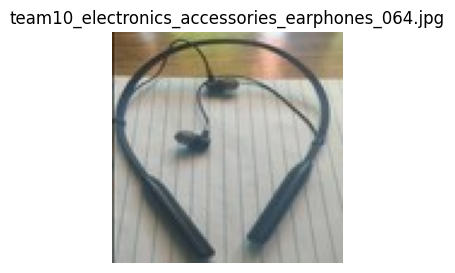


🔍 Results for: team10_electronics_accessories_earphones_064.jpg
  1. earphones    —  96.23%
  2. mouse        —   2.95%
  3. umbrella     —   0.44%


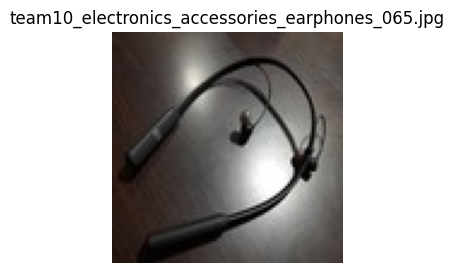


🔍 Results for: team10_electronics_accessories_earphones_065.jpg
  1. mouse        —  96.16%
  2. earphones    —   3.22%
  3. wristwatch   —   0.31%


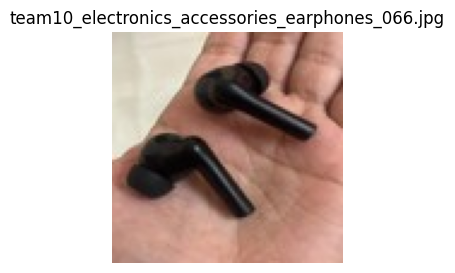


🔍 Results for: team10_electronics_accessories_earphones_066.jpg
  1. earphones    —  99.42%
  2. sneakers     —   0.47%
  3. wristwatch   —   0.06%


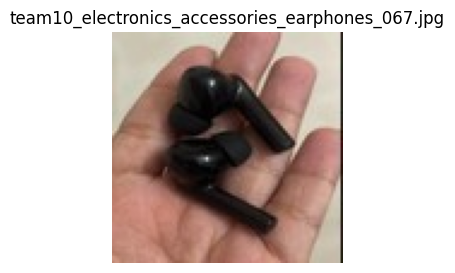


🔍 Results for: team10_electronics_accessories_earphones_067.jpg
  1. earphones    —  95.08%
  2. sneakers     —   4.02%
  3. wristwatch   —   0.70%


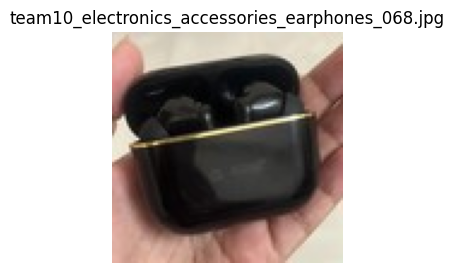


🔍 Results for: team10_electronics_accessories_earphones_068.jpg
  1. earphones    —  99.69%
  2. wristwatch   —   0.12%
  3. umbrella     —   0.06%


In [21]:
# === Cell 5 : Run on sample images (and display them) ===
import matplotlib.pyplot as plt
from PIL import Image

sample_images = [
    os.path.join(IMAGE_DIR, f)
    for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
][:5]

for path in sample_images:
    # --- show the image ---
    img = Image.open(path).convert("RGB")
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.axis("off")
    plt.title(os.path.basename(path))
    plt.show()

    # --- then run prediction and print results ---
    predict_image(path, show=False)   # show=False avoids re-plotting inside the function



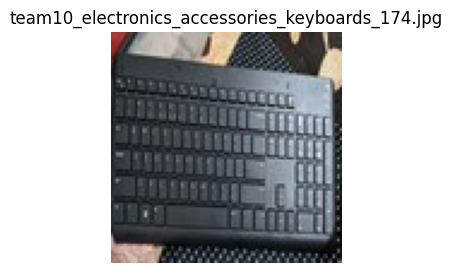


🔍 Results for: team10_electronics_accessories_keyboards_174.jpg
  1. keyboard     —  99.87%
  2. calculator   —   0.10%
  3. Cup          —   0.01%


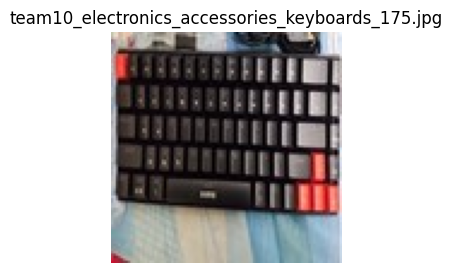


🔍 Results for: team10_electronics_accessories_keyboards_175.jpg
  1. keyboard     —  94.17%
  2. calculator   —   5.59%
  3. Cup          —   0.18%


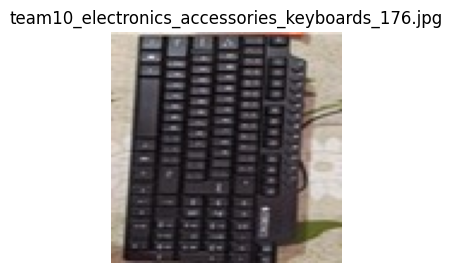


🔍 Results for: team10_electronics_accessories_keyboards_176.jpg
  1. keyboard     —  99.75%
  2. calculator   —   0.20%
  3. Cup          —   0.03%


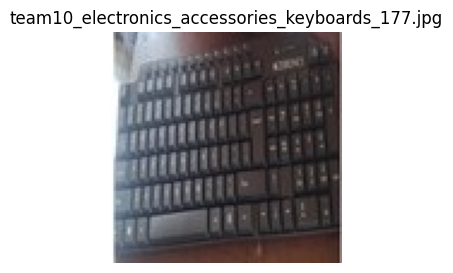


🔍 Results for: team10_electronics_accessories_keyboards_177.jpg
  1. keyboard     —  99.75%
  2. calculator   —   0.21%
  3. Cup          —   0.02%


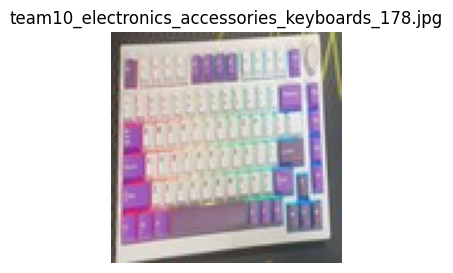


🔍 Results for: team10_electronics_accessories_keyboards_178.jpg
  1. keyboard     —  99.87%
  2. calculator   —   0.09%
  3. umbrella     —   0.01%


In [22]:
# === Cell 5 : Run on sample images (and display them) ===
import matplotlib.pyplot as plt
from PIL import Image

sample_images = [
    os.path.join(IMAGE_DIR, f)
    for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
][100:105]

for path in sample_images:
    # --- show the image ---
    img = Image.open(path).convert("RGB")
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.axis("off")
    plt.title(os.path.basename(path))
    plt.show()

    # --- then run prediction and print results ---
    predict_image(path, show=False)   # show=False avoids re-plotting inside the function

